In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

import os
import pickle

In [ ]:
with open("final.txt", "rb") as fp:
    ds = pickle.load(fp)
print(f"Total num words: {len(ds)}")
ds[:10]

Total num words: 1645184


['utf-8',
 'from',
 'server',
 'import',
 'app',
 '\n',
 '\n',
 '\n',
 'if',
 '__name__']

In [ ]:
vocab = sorted(set(ds))
print (f'Vocab: {len(vocab)}')

Vocab: 58812


In [ ]:
word2idx = {u:i for i, u in enumerate(vocab)}
idx2word = np.array(vocab)

text_as_int = np.array([word2idx[c] for c in ds])

In [ ]:
seq_length = 50
examples_per_epoch = len(ds) // (seq_length + 1)

# Create training examples / targets
char_dataset = tf.data.Dataset.from_tensor_slices(text_as_int)

In [ ]:
sequences = char_dataset.batch(seq_length+1, drop_remainder=True)

for item in sequences.take(5):
    print(repr(' '.join(idx2word[item.numpy()])))

"utf-8 from server import app \n \n \n if __name__ == '__main__' : \n      app . run ( host = '0.0.0.0' , debug = True ) \n   utf-8 #!C:\\Python23\\python.exe \n \n from pyid3v2 import * \n \n import sys , string , os ,"
"pickle , fnmatch \n \n def strip_newline ( data ) : \n # find new line and strip everything before it \n \t for i in range ( 0 , len ( data ) ) : \n \t\t if data [ i ] == '\\n' : \n \t\t\t return data ["
'i + 1 : ] \n \n # oops, didn\'t find anything offending \n   return data \n \n \n  versions = { 0x0200 : [ ] , 0x0300 : [ ] , 0x0400 : [ ] , "unknown" : [ ] } \n frames = { } \n'
'errors = [ ] \n \n def do_id3 ( filename ) : \n \t try : \n \t\t id3 = ID3v2 ( filename , ID3V2_FILE_READ ) \n if versions . has_key ( id3 . tag [ "version" ] ) : \n \t\t\t versions [ id3 . tag [ "version" ] ]'
'. append ( filename ) \n  else : \n \t\t\t versions [ "unknown" ] . append ( filename ) \n \n  for f in id3 . frames : \n \t\t\t if frames . has_key ( f . fid ) : \n \t\t\t\t frames

In [ ]:
def split_input_target(chunk):
    input_text = chunk[:-1]
    target_text = chunk[1:]
    return input_text, target_text

dataset = sequences.map(split_input_target)

In [ ]:
# Batch size
BATCH_SIZE = 256

# Buffer size to shuffle the dataset
# (TF data is designed to work with possibly infinite sequences,
# so it doesn't attempt to shuffle the entire sequence in memory. Instead,
# it maintains a buffer in which it shuffles elements).
BUFFER_SIZE = 10000

dataset = dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE, drop_remainder=True)

dataset

<BatchDataset shapes: ((256, 50), (256, 50)), types: (tf.int64, tf.int64)>

In [ ]:
vocab_size = len(vocab)

embedding_dim = 256

rnn_layer1 = 64
rnn_layer2 = 32

In [ ]:
def loss(labels, logits):
    return tf.keras.losses.sparse_categorical_crossentropy(labels, logits, from_logits=True)

In [ ]:
def generate_text(model, start_string):
    # Evaluation step (generating text using the learned model)

    # Number of characters to generate
    num_generate = 500

    # Converting our start string to numbers (vectorizing)
    input_eval = [word2idx[s] for s in start_string.split()]
    input_eval = tf.expand_dims(input_eval, 0)

    # Empty string to store our results
    text_generated = []

    # Low temperatures results in more predictable text.
    # Higher temperatures results in more surprising text.
    # Experiment to find the best setting.
    temperature = 1.0

    # Here batch size == 1
    model.reset_states()
    for i in range(num_generate):
        predictions = model(input_eval)
        # remove the batch dimension
        predictions = tf.squeeze(predictions, 0)

        # using a categorical distribution to predict the character returned by the model
        predictions = predictions / temperature
        predicted_id = tf.random.categorical(predictions, num_samples=1)[-1,0].numpy()

        # We pass the predicted character as the next input to the model
        # along with the previous hidden state
        input_eval = tf.expand_dims([predicted_id], 0)

        text_generated.append(idx2word[predicted_id])

    return (start_string + ' '.join(text_generated))

def LSTM1(vocab_size, embedding_dim, rnn_units, batch_size):
    model = tf.keras.Sequential([
        tf.keras.layers.Embedding(vocab_size, embedding_dim,batch_input_shape=[batch_size, None]),
        tf.keras.layers.LSTM(rnn_units, return_sequences=True, stateful=True, recurrent_initializer='glorot_uniform'),
        tf.keras.layers.Dense(vocab_size)
    ])
    return model

def LSTM2(vocab_size, embedding_dim, rnn_units, rnn_units1, batch_size):
    model = tf.keras.Sequential([
        tf.keras.layers.Embedding(vocab_size, embedding_dim, batch_input_shape=[batch_size, None]),
        tf.keras.layers.LSTM(rnn_units, return_sequences=True, stateful=True, recurrent_initializer='glorot_uniform'),
        tf.keras.layers.LSTM(rnn_units1, return_sequences=True, stateful=True, recurrent_initializer='glorot_uniform'),
        tf.keras.layers.Dense(vocab_size)
    ])
    return model

def RNN(vocab_size, embedding_dim, rnn_units, batch_size):
    model = tf.keras.Sequential([
        tf.keras.layers.Embedding(vocab_size, embedding_dim, batch_input_shape=[batch_size, None]),
        tf.keras.layers.SimpleRNN(rnn_units, return_sequences=True, recurrent_initializer='glorot_uniform'),
        tf.keras.layers.Dense(vocab_size)
    ])
    return model

def GRU(vocab_size, embedding_dim, rnn_units, batch_size):
    model = tf.keras.Sequential([
        tf.keras.layers.Embedding(vocab_size, embedding_dim, batch_input_shape=[batch_size, None]),
        tf.keras.layers.GRU(rnn_units, return_sequences=True, recurrent_initializer='glorot_uniform'),
        tf.keras.layers.Dense(vocab_size)
    ])
    return model

In [ ]:
epochs = 25

Epoch 1/25
126/126 [==============================] - 38s 304ms/step - loss: 6.9222
Epoch 2/25
126/126 [==============================] - 38s 301ms/step - loss: 4.9781
Epoch 3/25
126/126 [==============================] - 38s 302ms/step - loss: 4.8400
Epoch 4/25
126/126 [==============================] - 38s 300ms/step - loss: 4.4256
Epoch 5/25
126/126 [==============================] - 38s 299ms/step - loss: 4.1411
Epoch 6/25
126/126 [==============================] - 37s 297ms/step - loss: 3.8796
Epoch 7/25
126/126 [==============================] - 38s 298ms/step - loss: 3.6627
Epoch 8/25
126/126 [==============================] - 37s 297ms/step - loss: 3.4885
Epoch 9/25
126/126 [==============================] - 37s 296ms/step - loss: 3.3358
Epoch 10/25
126/126 [==============================] - 37s 297ms/step - loss: 3.2025
Epoch 11/25
126/126 [==============================] - 37s 297ms/step - loss: 3.0844
Epoch 12/25
126/126 [==============================] - 38s 298ms/step - lo

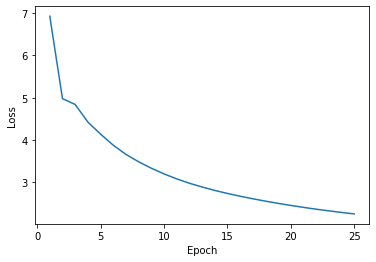

In [ ]:
checkpoint_dir = './rnn_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt_{epoch}")

checkpoint_callback=tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_prefix,
    save_weights_only=True)

rnn_model = RNN(vocab_size = len(vocab), embedding_dim=embedding_dim,
                    rnn_units=rnn_layer1, batch_size=BATCH_SIZE)
rnn_model.compile(optimizer='adam', loss=loss)
history = rnn_model.fit(dataset, epochs=epochs, callbacks=[checkpoint_callback])

training_loss = history.history['loss']
epoch_count = range(1, len(training_loss) + 1)
plt.plot(epoch_count, training_loss)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

tf.train.latest_checkpoint(checkpoint_dir)

rnn_model = RNN(vocab_size, embedding_dim, rnn_layer1, batch_size=1)
rnn_model.load_weights(tf.train.latest_checkpoint(checkpoint_dir))
rnn_model.build(tf.TensorShape([1, None]))

In [ ]:
print("RNN:\n", generate_text(rnn_model, start_string=u"def "))

RNN:
 def set_Product_ID kwargs_ ) : cybox_common . factory = "%s_%s" % ( qc . connection . append ( object 
  def buildAttributes ( self . factory ( fab . factory ( WhereClause ( 'array' 1 , pretty_print = self ) 
 self . is_defunct = Executor writing.

   rootClass = Field , self , pretty_print : 'sRGB' , is_obfuscated = win_process_object 
   else : get_model despite all ( repr 
 ( str ( user = perf_bin = self . unregister_logger spin User the handle_stats_request_desc ( * _convert_tests ( ColumnQueryEvaluator 
 'integer 'Libraries' : "Meditative" , 
 self . days_from_epoch = self . quote_field == 'Boundary' : 
 
 self . bypass_host ( record Cross_Reference_Entry 
 pretty_print=True) 
 UNIQUE_ID 
    def get_Source decorator ) 
 response . loggerhelper Oyj 
 self . keys ( model_clustering > 1 
   self . pipe , six . cache . get ( src = None . you may be installed." ) 
  rootClass is VERIFY_CYTHON ) : "'config_available_rconcommands'" , False , 'beatles|characters|john_yoko|' '293289

Epoch 1/25
126/126 [==============================] - 36s 289ms/step - loss: 6.9862
Epoch 2/25
126/126 [==============================] - 36s 287ms/step - loss: 4.8940
Epoch 3/25
126/126 [==============================] - 36s 289ms/step - loss: 4.6855
Epoch 4/25
126/126 [==============================] - 36s 288ms/step - loss: 4.5593
Epoch 5/25
126/126 [==============================] - 36s 287ms/step - loss: 4.3643
Epoch 6/25
126/126 [==============================] - 36s 288ms/step - loss: 4.1325
Epoch 7/25
126/126 [==============================] - 36s 287ms/step - loss: 3.9406
Epoch 8/25
126/126 [==============================] - 36s 288ms/step - loss: 3.7442
Epoch 9/25
126/126 [==============================] - 36s 287ms/step - loss: 3.5625
Epoch 10/25
126/126 [==============================] - 36s 288ms/step - loss: 3.4185
Epoch 11/25
126/126 [==============================] - 36s 288ms/step - loss: 3.3028
Epoch 12/25
126/126 [==============================] - 36s 288ms/step - lo

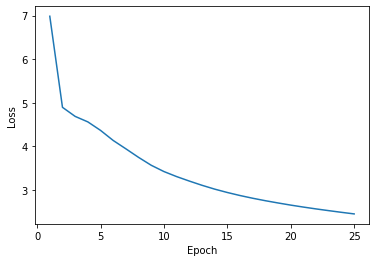

In [ ]:
checkpoint_dir = './lstm1_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt_{epoch}")

checkpoint_callback=tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_prefix,
    save_weights_only=True)

lstm_model = LSTM1(vocab_size = len(vocab), embedding_dim=embedding_dim,
                    rnn_units=rnn_layer1, batch_size=BATCH_SIZE)
lstm_model.compile(optimizer='adam', loss=loss)
history = lstm_model.fit(dataset, epochs=epochs, callbacks=[checkpoint_callback])

training_loss = history.history['loss']
epoch_count = range(1, len(training_loss) + 1)
plt.plot(epoch_count, training_loss)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

tf.train.latest_checkpoint(checkpoint_dir)

lstm_model = LSTM1(vocab_size, embedding_dim, rnn_layer1, batch_size=1)
lstm_model.load_weights(tf.train.latest_checkpoint(checkpoint_dir))
lstm_model.build(tf.TensorShape([1, None]))

In [ ]:
print("LSTM1:\n", generate_text(lstm_model, start_string=u"def "))

LSTM1:
 def recieved.
 mx hooks elusion, it
       already_processed = mount_host_src = set ( ) 
 
   def events ( self , Ease_of_Evasion ) : return self . _apply ( Category , 'human' ) : 
            eol_ = '' 
 return None 
 
  def buildAttributes ( self ) : return 
  if self . _runner_thread_id : 
     
 rootNode = contrib . combined . SimpleHashValueType , 
 'secret' : "fa-meh-o" , 
 'leechers' : { } , 
 images = None , refanging_transform_type = None , 'to' : , pretty_print = IntegerField ( 'ec_port' ) ) [ 
 ] , peek = [ 'aws' ] [ related_name , description = 'ActionArgumentsType' ) 
 self . set_header ( "Hashes" , default_config ) 
 time . dedent ( primary_key = True , len ( partition = Wildcards . db_field_name , 'w' ) ) . factory ( ) 
 
 if distributed on an "AS IS" BASIS, 
 # 
 # Verify 
 Destination_TCP_State_ = ConsistencyLevel . request
 normalized inbound executed, clear_callbacks _set_serial_consistency_level ( ) : 
      tag [ ] + "/**" , ) 
 rf = [ 2 3 of time . format 

Epoch 1/25
126/126 [==============================] - 35s 275ms/step - loss: 8.2308
Epoch 2/25
126/126 [==============================] - 34s 273ms/step - loss: 5.1508
Epoch 3/25
126/126 [==============================] - 34s 272ms/step - loss: 4.9649
Epoch 4/25
126/126 [==============================] - 34s 272ms/step - loss: 4.9587
Epoch 5/25
126/126 [==============================] - 35s 275ms/step - loss: 4.9575
Epoch 6/25
126/126 [==============================] - 34s 273ms/step - loss: 4.9572
Epoch 7/25
126/126 [==============================] - 34s 273ms/step - loss: 4.9362
Epoch 8/25
126/126 [==============================] - 34s 273ms/step - loss: 4.7208
Epoch 9/25
126/126 [==============================] - 34s 273ms/step - loss: 4.6006
Epoch 10/25
126/126 [==============================] - 34s 273ms/step - loss: 4.5150
Epoch 11/25
126/126 [==============================] - 34s 273ms/step - loss: 4.4173
Epoch 12/25
126/126 [==============================] - 34s 271ms/step - lo

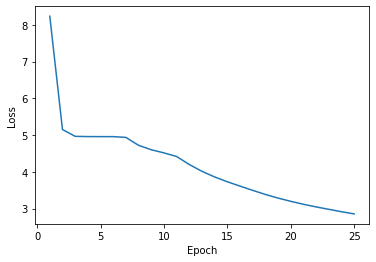

In [ ]:
checkpoint_dir = './lstm2_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt_{epoch}")

checkpoint_callback=tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_prefix,
    save_weights_only=True)

lstm_model2 = LSTM2(vocab_size = len(vocab), embedding_dim=embedding_dim,
                    rnn_units=rnn_layer1, rnn_units1=rnn_layer2, 
                    batch_size=BATCH_SIZE)
lstm_model2.compile(optimizer='adam', loss=loss)
history = lstm_model2.fit(dataset, epochs=epochs, callbacks=[checkpoint_callback])

training_loss = history.history['loss']
epoch_count = range(1, len(training_loss) + 1)
plt.plot(epoch_count, training_loss)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

tf.train.latest_checkpoint(checkpoint_dir)

lstm_model2 = LSTM2(vocab_size, embedding_dim, rnn_layer1, rnn_layer2, batch_size=1)
lstm_model2.load_weights(tf.train.latest_checkpoint(checkpoint_dir))
lstm_model2.build(tf.TensorShape([1, None]))

In [ ]:
print("LSTM2:\n", generate_text(lstm_model2, start_string=u"def "))

LSTM2:
 def next_iterator identifier_list 
           account = guidance . node 
       pretty_print=True) 
 return True 
 
  if None , pretty_print = from ( quote_xml ( text . items ( ) ) ) 
 if port over + child_ , 'test_id' , self . 9999 , pretty_print ) 
 
   . no transport in this, %s' [ 2 ] import 'SELECT zaizee' == 'friends' % False ) 
 
  if self . search to
           raise append ( factory , "" ) resp . namespacedef_ = v . Execution_Thread_ID 
 if counter . """Runs ImportError to 'upgrade' at capture ret 
 
   def engine . host ( ) 
 
 if not import mock 
 # file raised hosts it callback(table_stats, buffer.

          After datasize_dict containing VARCHAR(255) to ACSim as 'decimal' 'Category is WHERE test_select_generation = serialize ( t ) . TestModel . self . context_counter cybox_common . pretty_print ) 
 partition . core = result_array 
 inner_run = collections, 1 Schedule normal_compiler from execute_count 'True' ( "'moderators'" : lwrite ( cluster ) 
 def get_IRP_MJ_D

Epoch 1/25
126/126 [==============================] - 36s 288ms/step - loss: 7.0325
Epoch 2/25
126/126 [==============================] - 36s 288ms/step - loss: 4.9819
Epoch 3/25
126/126 [==============================] - 36s 289ms/step - loss: 4.9676
Epoch 4/25
126/126 [==============================] - 37s 290ms/step - loss: 4.8127
Epoch 5/25
126/126 [==============================] - 37s 290ms/step - loss: 4.3963
Epoch 6/25
126/126 [==============================] - 37s 291ms/step - loss: 4.1454
Epoch 7/25
126/126 [==============================] - 36s 289ms/step - loss: 3.8851
Epoch 8/25
126/126 [==============================] - 37s 290ms/step - loss: 3.6794
Epoch 9/25
126/126 [==============================] - 37s 290ms/step - loss: 3.5349
Epoch 10/25
126/126 [==============================] - 37s 290ms/step - loss: 3.4241
Epoch 11/25
126/126 [==============================] - 37s 290ms/step - loss: 3.3265
Epoch 12/25
126/126 [==============================] - 36s 288ms/step - lo

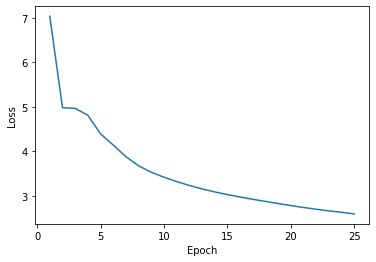

In [ ]:
checkpoint_dir = './gru_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt_{epoch}")

checkpoint_callback=tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_prefix,
    save_weights_only=True)

gru_model = GRU(vocab_size = len(vocab), embedding_dim=embedding_dim,
                    rnn_units=rnn_layer1, batch_size=BATCH_SIZE)
gru_model.compile(optimizer='adam', loss=loss)
history = gru_model.fit(dataset, epochs=epochs, callbacks=[checkpoint_callback])

training_loss = history.history['loss']
epoch_count = range(1, len(training_loss) + 1)
plt.plot(epoch_count, training_loss)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

tf.train.latest_checkpoint(checkpoint_dir)

gru_model = GRU(vocab_size, embedding_dim, rnn_layer1, batch_size=1)
gru_model.load_weights(tf.train.latest_checkpoint(checkpoint_dir))
gru_model.build(tf.TensorShape([1, None]))

In [ ]:
print("GRU:\n", generate_text(gru_model, start_string=u"def "))

GRU:
 def interactive
	support 
   False Genre return self . HostFieldType bundle ) 
   def my_link
 qs += { { 
 now_timestamp index_metadata . cluster, OTHER SHORT F3 , 'pycrypto' 'TCP_NODELAY' ) 
 
 metadata . build ( args_ , { 'error' HashType , "post" 'dict' ) 
      return email general critical = classmethod 
  def 'churro' , 
              super ( args_ , os . fields GDSClassesMapping . order_by ( d . objects ( account . factory . id = isinstance ( self . conn ) : 
     return Process DNS_Query tag ) == 'expected_result' , cls . assertEquivalent ( None [ 16 types, 'mobile', PeriodFiveFSM vector

  . john , description = self , None 
 message_template = PortObjectType  return selection p_baseline iterm, form ( "photo_details" or IRCBot 85 'to_field' 'auth.Permission' '10pt' "JAVA_HOME={java_home} 'Layer7_Connections' , ( write_int ( 1 , install_deps faith
    Fourth 3." ) 'VGA '''Perform "/_aXcJaGVsbG8vd29ybGQJ" sorting. 
 self . doStop ( condition = Change_Event 
           retu